<div class="alert alert-block alert-info">
Section of the book chapter: <b>6.2.1 Future on Data Level: Generative Adversarial Networks</b>
</div>

# 6. Generative Adversarial Network (GAN)

Example by adapted from [Renu Khandelwal](https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3)

**Table of Contents**

* [6.1 GAN Setup](#6.1-GAN-Setup)
* [6.2 Train GAN](#6.2-Train-GAN)

**Learnings:**

- how to set up a GAN,
- how to train a GAN.



### Packages

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

import utils

Using TensorFlow backend.


### Read in Data

**Dataset:** Felix M. Riese and Sina Keller, "Hyperspectral benchmark dataset on soil moisture", Dataset, Zenodo, 2018. [DOI:10.5281/zenodo.1227836](http://doi.org/10.5281/zenodo.1227836) and [GitHub](https://github.com/felixriese/hyperspectral-soilmoisture-dataset)

**Introducing paper:** Felix M. Riese and Sina Keller, “Introducing a Framework of Self-Organizing Maps for Regression of Soil Moisture with Hyperspectral Data,” in IGARSS 2018 - 2018 IEEE International Geoscience and Remote Sensing Symposium, Valencia, Spain, 2018, pp. 6151-6154. [DOI:10.1109/IGARSS.2018.8517812](https://doi.org/10.1109/IGARSS.2018.8517812)

In [2]:
X_train, X_test, y_train, y_test = utils.get_xy_split()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(339, 125) (340, 125) (339,) (340,)


### Keras Helper Functions

In [3]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

***

## 6.1 GAN Setup

Content:

- [6.1.1 Generator](#6.1.1-Generator)
- [6.1.2 Discriminator](#6.1.2-Discriminator)
- [6.1.3 Full GAN](#6.1.3-Full-GAN)
- [6.1.4 Plot script](#6.1.4-Plot-script)

### 6.1.1 Generator

In [4]:
def get_generator():
    generator = Sequential()
    generator.add(Dense(units=256, input_dim=50))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=125, activation='tanh'))
    
    generator.compile(loss='mean_squared_error', optimizer=adam_optimizer())
    return generator

### 6.1.2 Discriminator

In [5]:
def get_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024, input_dim=125))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

### 6.1.3 Full GAN

In [6]:
def get_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(50,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer="adam")
    return gan

### 6.1.4 Plot script

In [7]:
def plot_generated_data(epoch, generator, examples=20, dim=(50,1), figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 50])
    generated_data = generator.predict(noise)
    generated_data = generated_data.reshape(examples,125,1)
    plt.figure(figsize=figsize)
    for i in range(generated_data.shape[0]):
        plt.plot(generated_data[i], alpha=0.2)
    plt.xlabel("Hyperspectral Bands")
    plt.ylabel("Reflectance")
    plt.tight_layout()
    plt.savefig('plots/gan_generated_image %d.png' %epoch)

***

## 6.2 Train GAN

In [8]:
def training(epochs=1, batch_size=8):
    
    # Loading the data
    (X_train, y_train, X_test, y_test) = utils.get_xy_split()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = get_generator()
    discriminator = get_discriminator()
    gan = get_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        for _ in tqdm(range(batch_size)):
            # generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 50])
            
            # Generate fake data
            generated_data = generator.predict(noise)
            
            # Get randomly real data
            data_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            # Construct different batches of real and fake data 
            X = np.concatenate([data_batch, generated_data])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            # Pre-train discriminator on  fake and real data  before starting
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 50])
            y_gen = np.ones(batch_size)
            
            # Fixed discriminator weights during the training
            discriminator.trainable = False
            
            # Training  the GAN by alternating the training of the discriminator 
            # and training the chained GAN model with discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
            
            print("Epoch %d" %e)
            plot_generated_data(e, generator)

W0821 17:59:23.227977 4410250688 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 17:59:23.289942 4410250688 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 17:59:23.315822 4410250688 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 17:59:23.450966 4410250688 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 17:59:23.490324 4410250688 deprecation_wrapper.py:119] From /usr/local

Epoch 1


100%|██████████| 8/8 [00:00<00:00, 45.14it/s]


Epoch 20


100%|██████████| 8/8 [00:00<00:00, 60.12it/s]


Epoch 40


100%|██████████| 8/8 [00:00<00:00, 64.05it/s]


Epoch 60


100%|██████████| 8/8 [00:00<00:00, 65.66it/s]


Epoch 80


100%|██████████| 8/8 [00:00<00:00, 29.31it/s]


Epoch 100


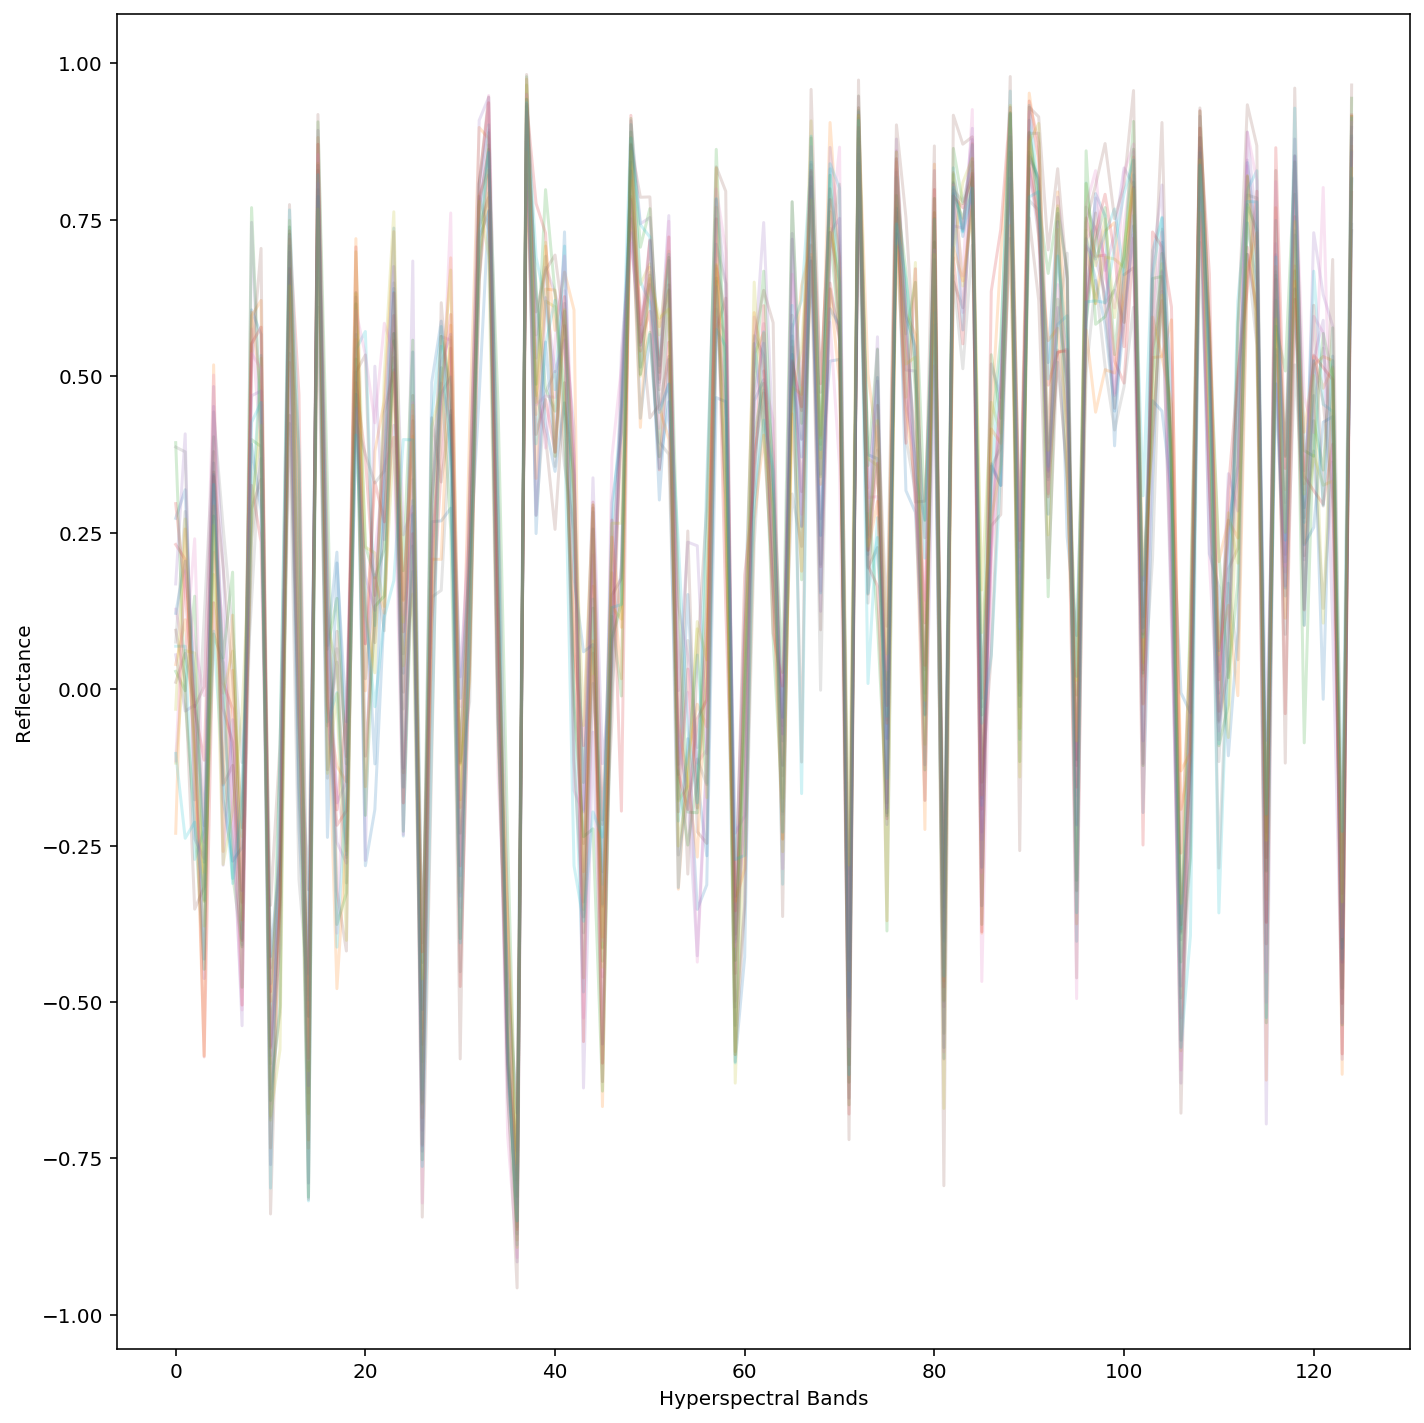

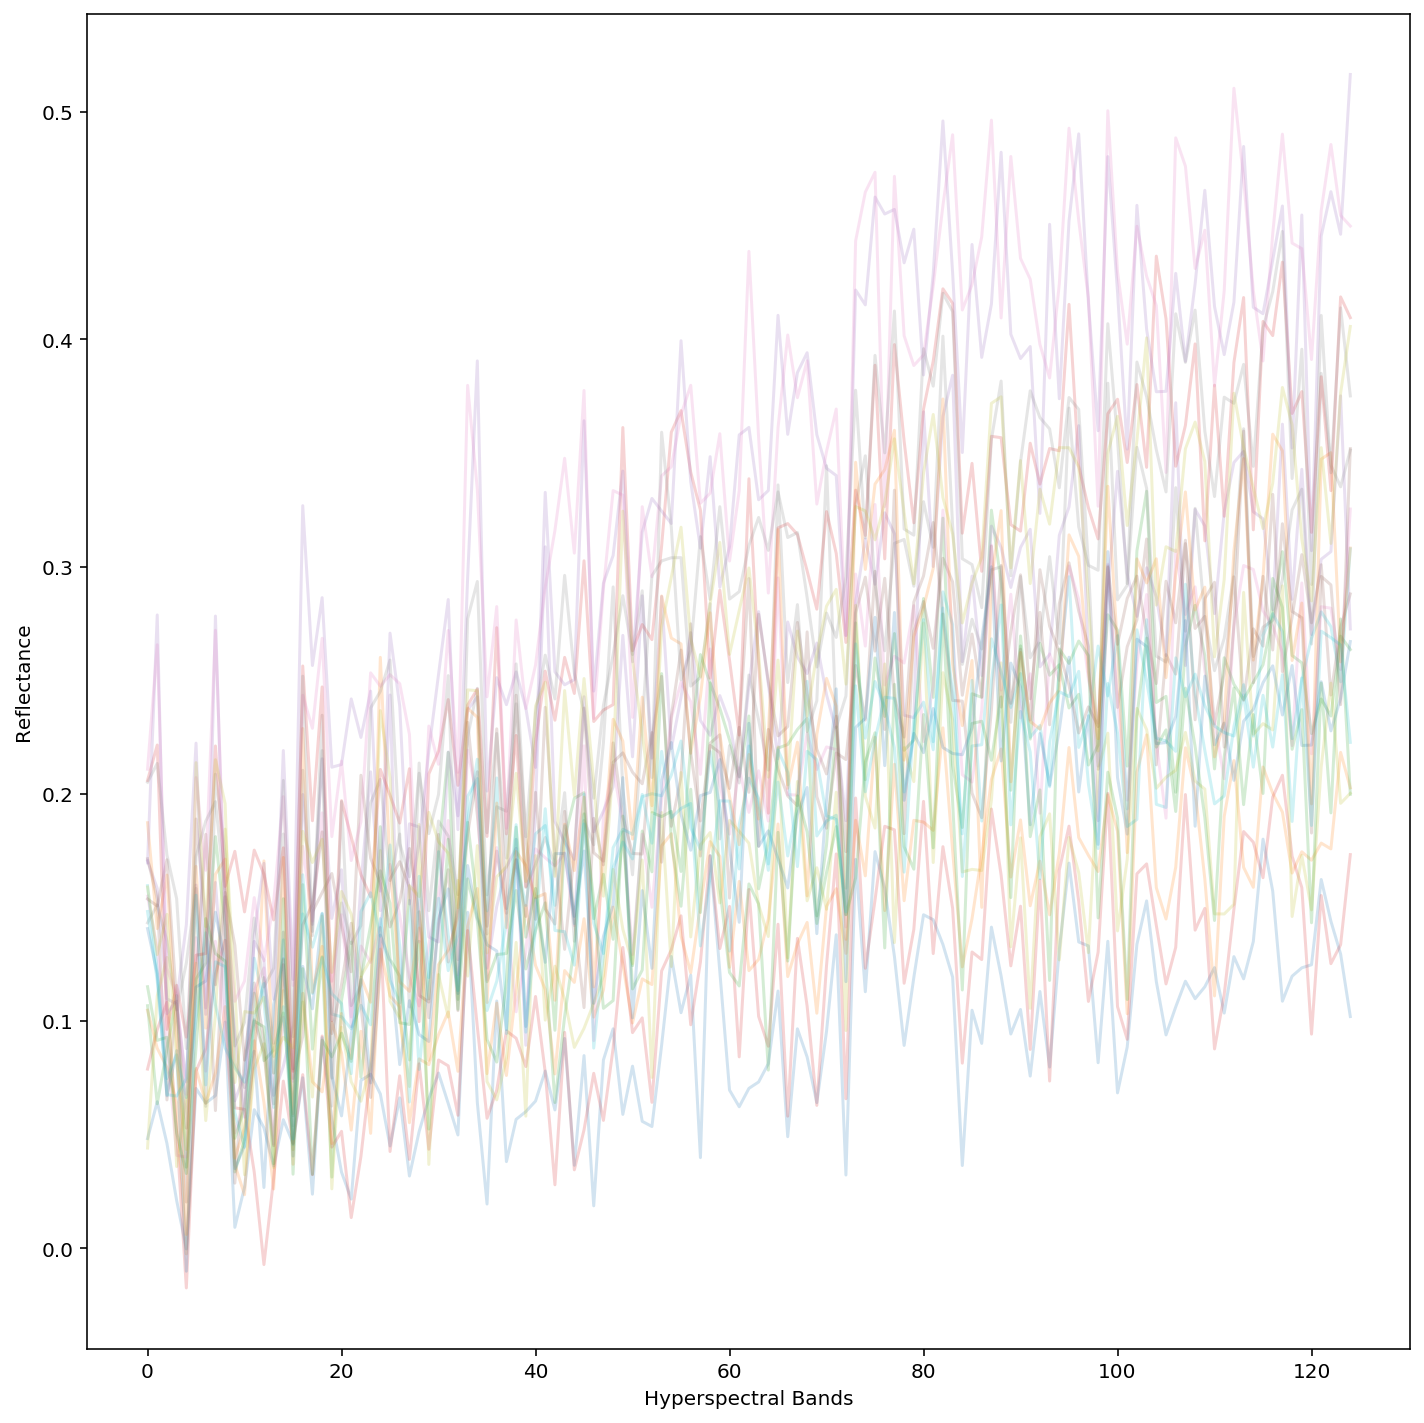

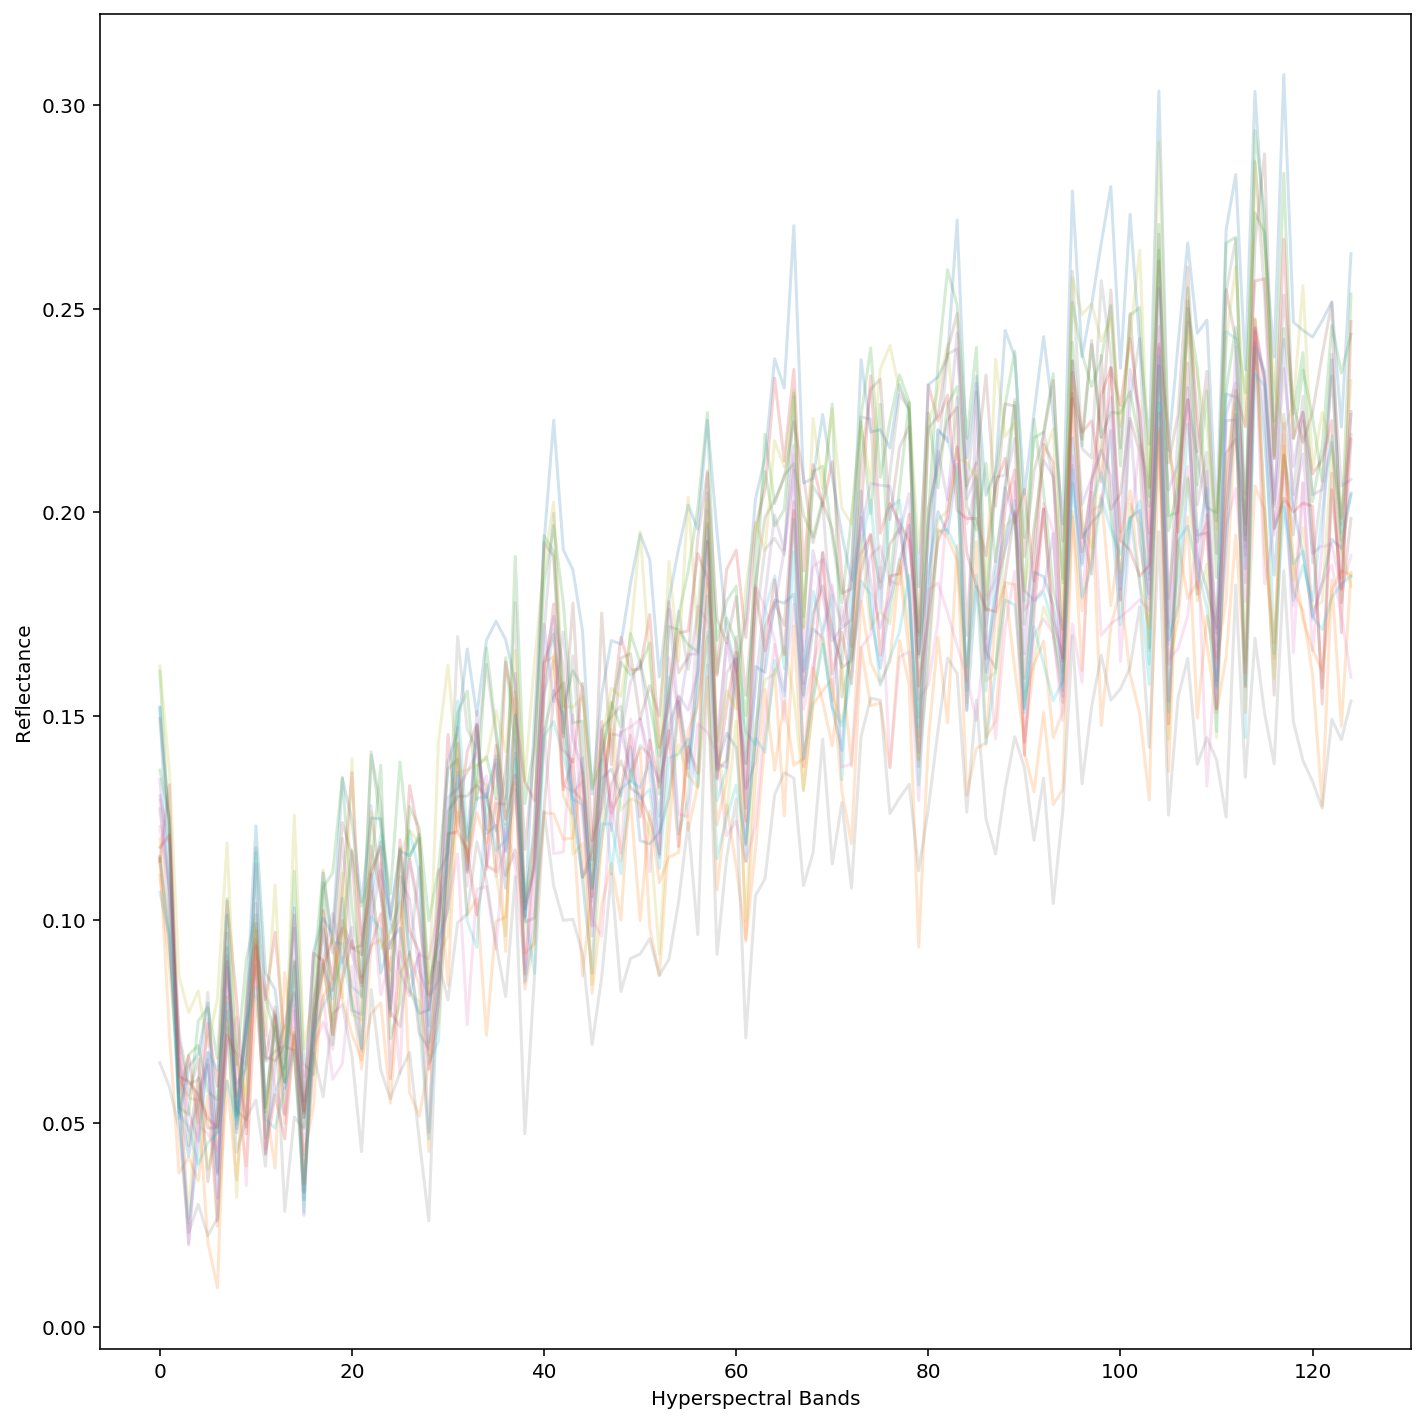

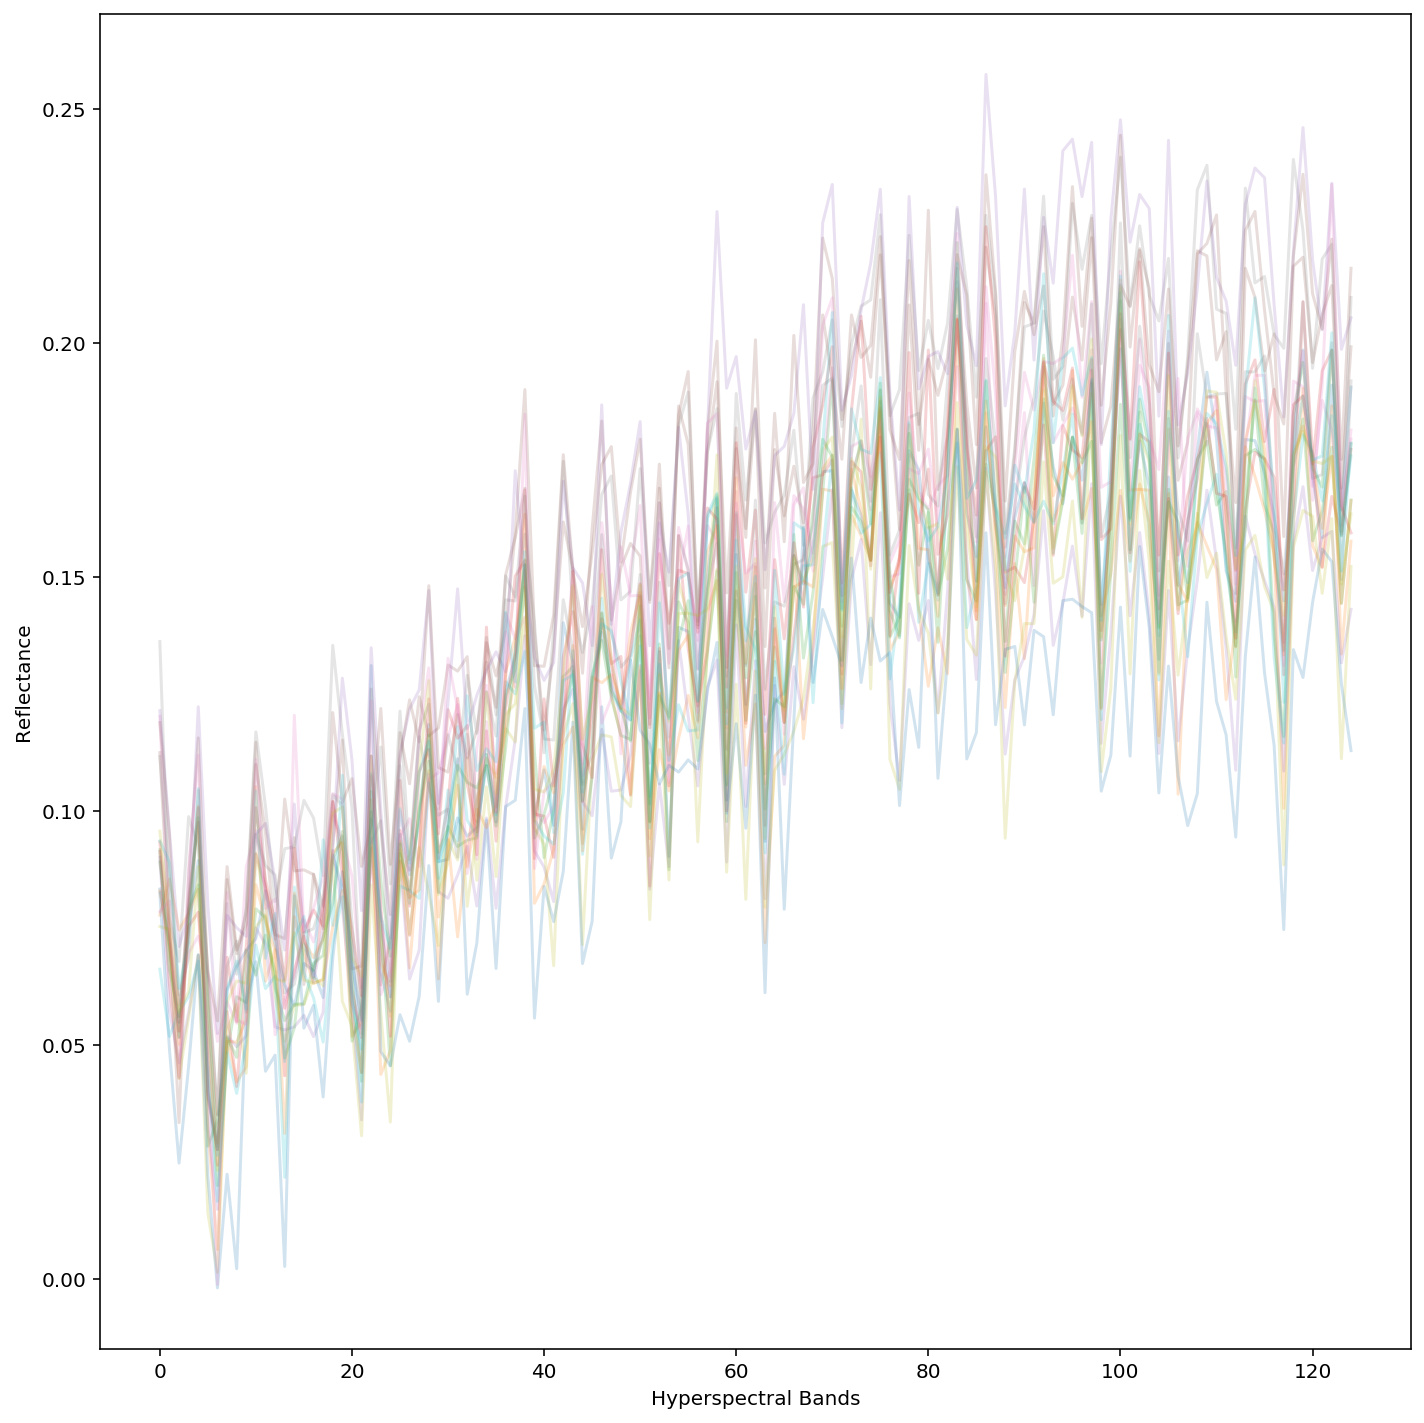

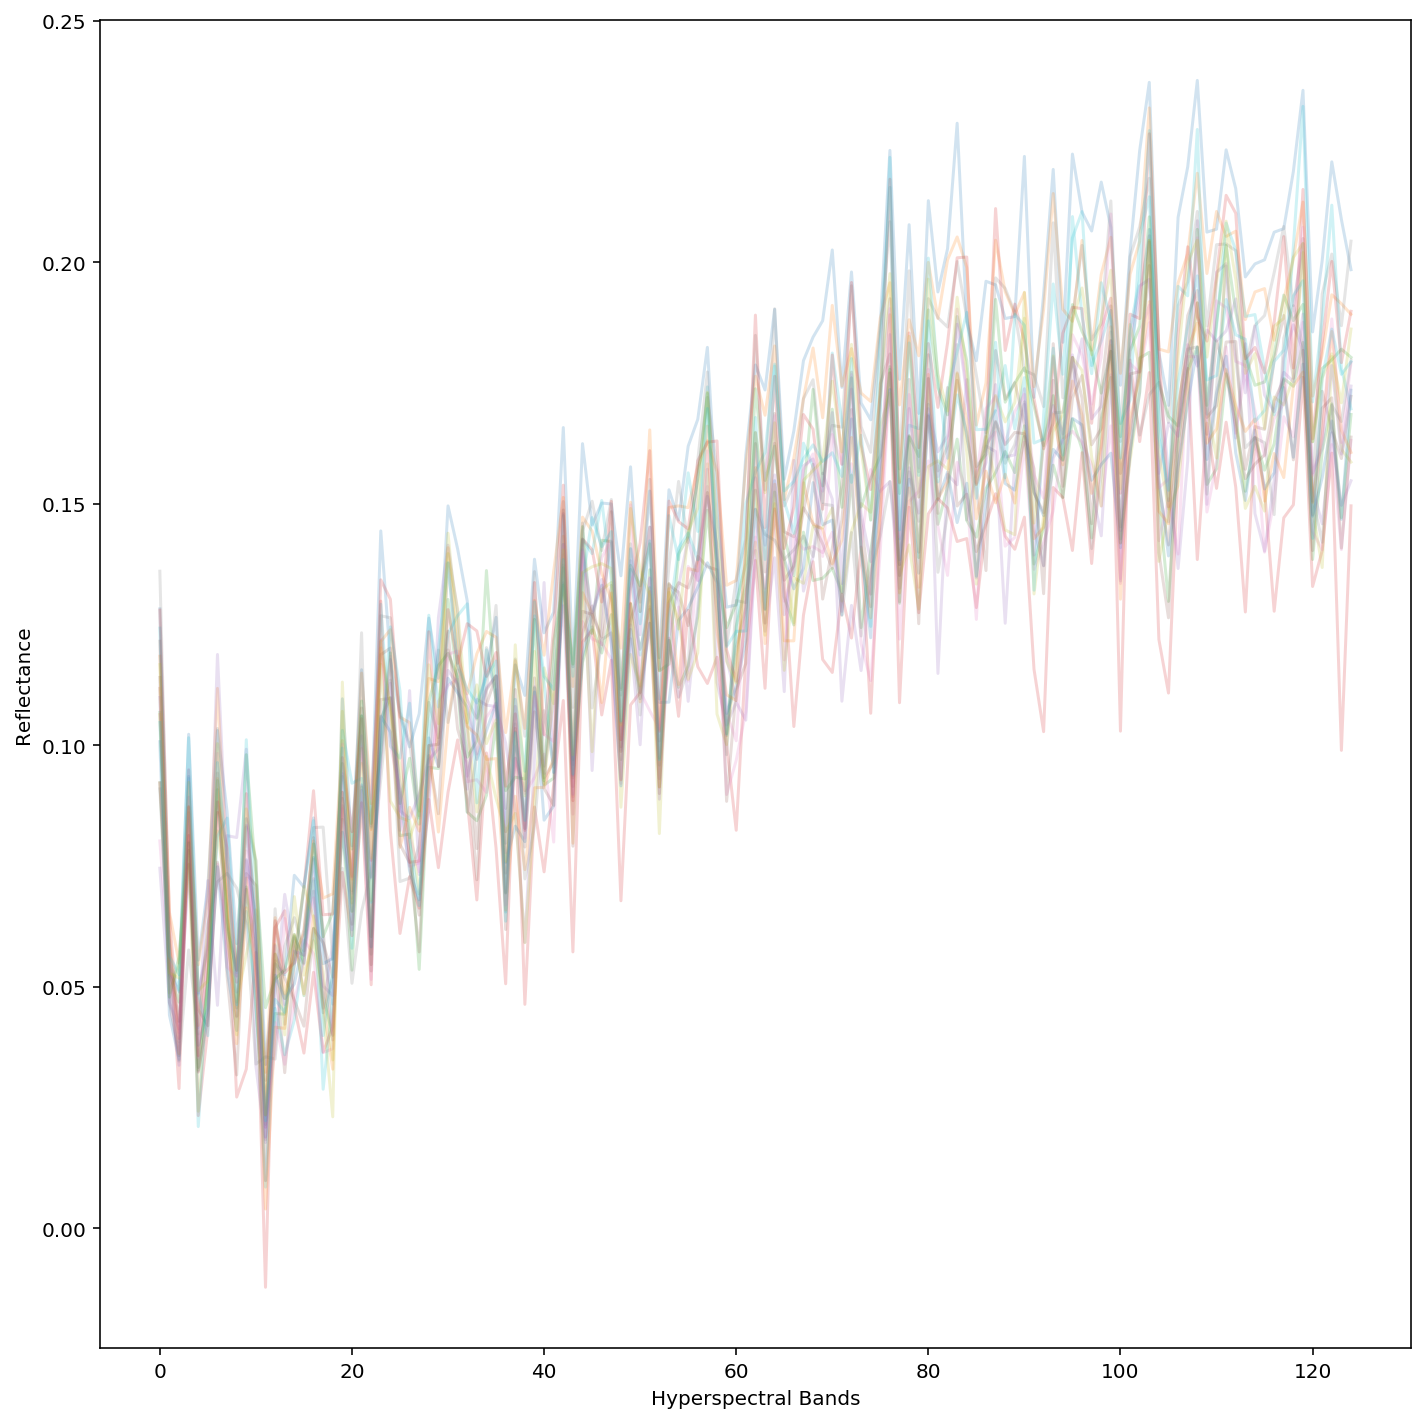

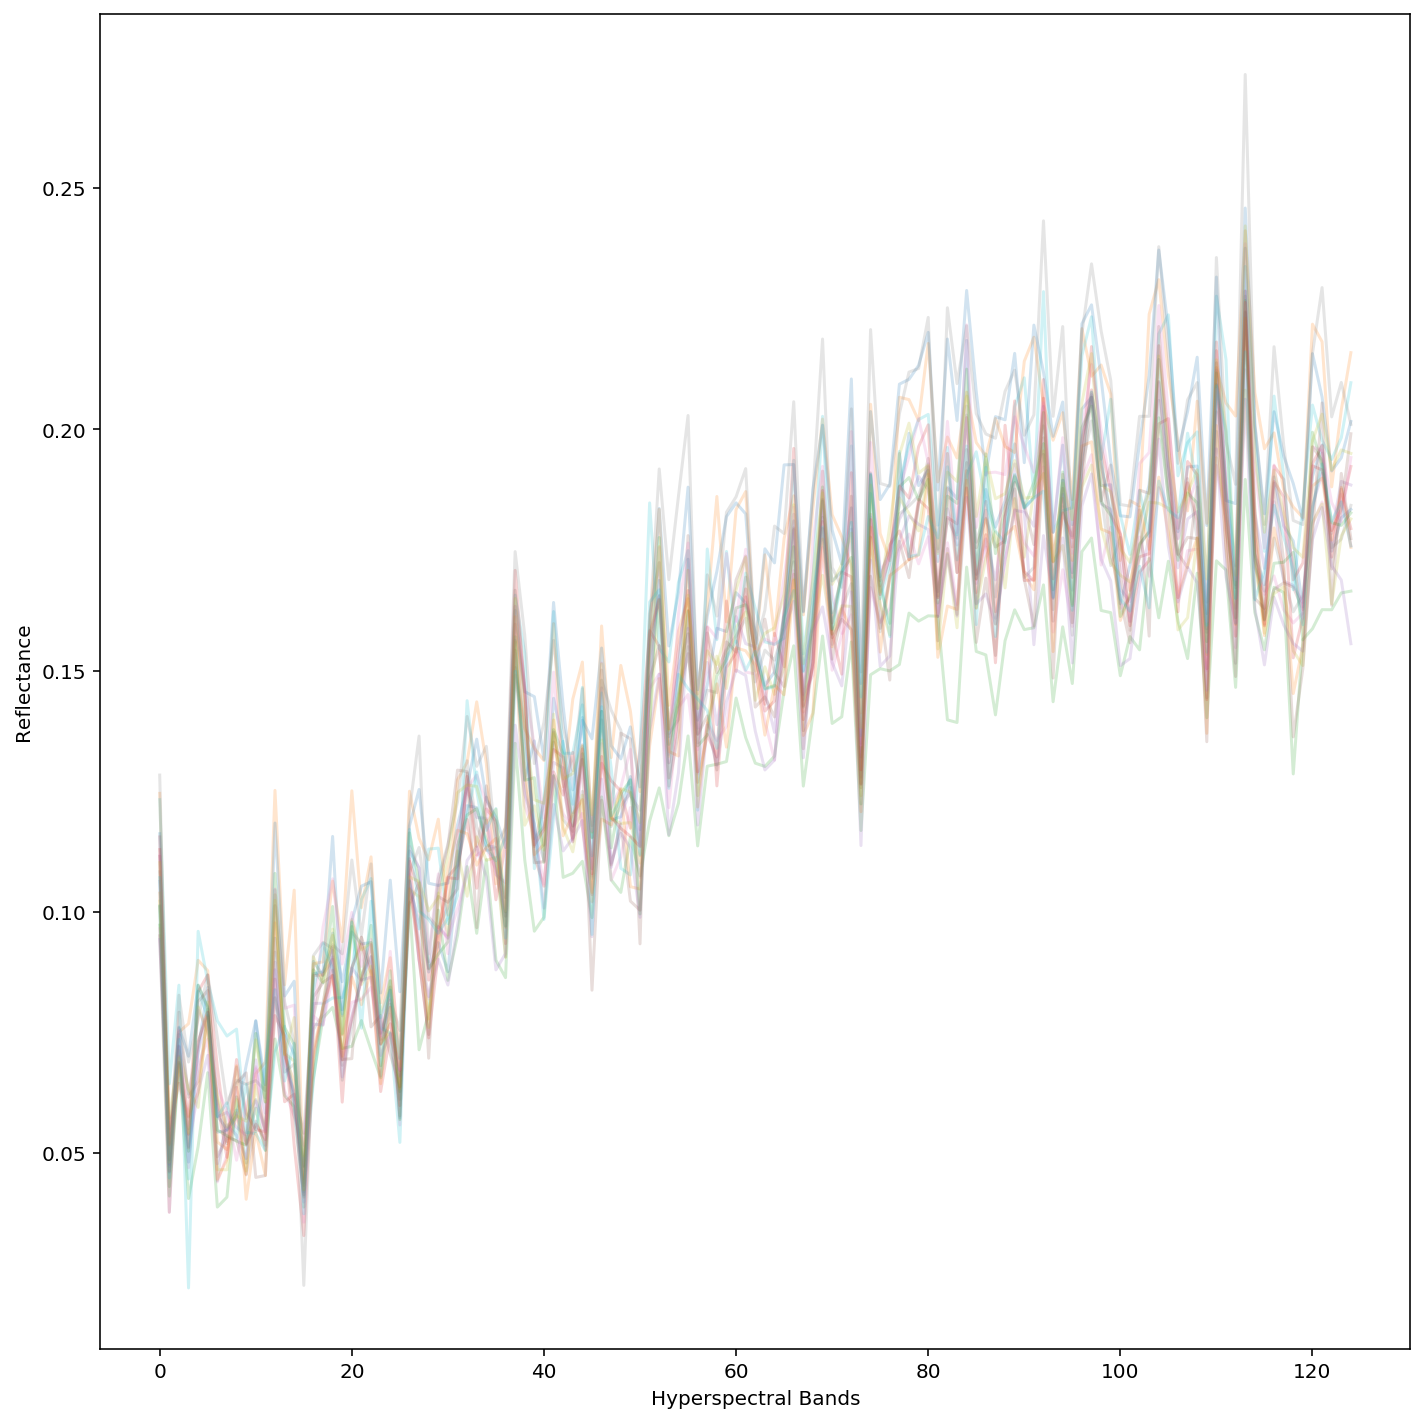

In [9]:
# NBVAL_IGNORE_OUTPUT

training(100,8)